In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from helper import plot_classifier

In [2]:
df = pd.read_csv("Churn_Modelling.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Data Cleaning

In [4]:
## Irrelevante Spalten entfernen

In [5]:
df.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)

## One-Hot Encoding
Geography, Gender

In [6]:
geo = pd.get_dummies(df["Geography"], drop_first=True)
gender = pd.get_dummies(df["Gender"], drop_first=True)
df = pd.concat([df, geo, gender], axis=1)
df.drop(["Geography", "Gender"], axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Age              10000 non-null  int64  
 2   Tenure           10000 non-null  int64  
 3   Balance          10000 non-null  float64
 4   NumOfProducts    10000 non-null  int64  
 5   HasCrCard        10000 non-null  int64  
 6   IsActiveMember   10000 non-null  int64  
 7   EstimatedSalary  10000 non-null  float64
 8   Exited           10000 non-null  int64  
 9   Germany          10000 non-null  uint8  
 10  Spain            10000 non-null  uint8  
 11  Male             10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


## Skalieren Sie die Features mit einem StandardScaler

In [8]:
from sklearn.model_selection import train_test_split
X = list(df.columns)
X.remove("Exited")
X = df[X]
y = df["Exited"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Naive Bayes

In [10]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [11]:
score = model.score(X_test, y_test)
print(f"Score: {score*100}%")
confusion_matrix(y_test, predictions)

Score: 79.10000000000001%


array([[1555,   52],
       [ 366,   27]])

# KNN

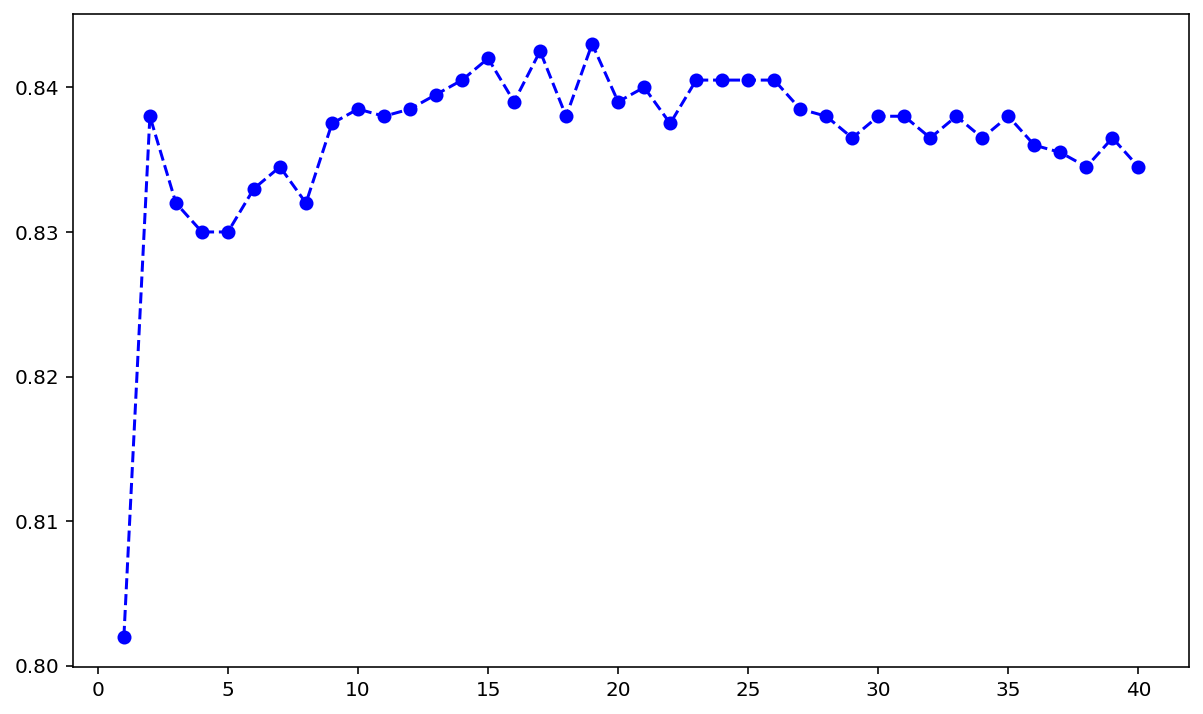

In [12]:
from sklearn.neighbors import KNeighborsClassifier

scores = []
predictions = []
for k in range(1,41):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))
    predictions.append(knn.predict(X_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,41), scores, color="blue", linestyle="dashed", marker="o")

In [13]:
best_n = np.array(scores).argmax()
print(f"das beste n ist {best_n+1} mit einem Score von {scores[best_n]*100}%")
confusion_matrix(y_test, predictions[best_n])

das beste n ist 19 mit einem Score von 84.3%


array([[1228,  379],
       [ 280,  113]])

# Vergleich
KNN schneidet somit um ca. 5% besser ab.
Überraschend ist, dass KNN ca 6 mal soviele False Positive und 4 mal soviele True Positive hat.

# SVM

In [14]:
linear = SVC(gamma='scale', C=1, kernel='linear', coef0=0.0)
linear.fit(X_train_scaled, y_train)
linear.score(X_test_scaled, y_test)

0.8035

In [15]:
poly = SVC(gamma='scale', C=1, kernel='poly', degree=2, coef0=1.0)
poly.fit(X_train_scaled, y_train)
poly.score(X_test_scaled, y_test)

0.857

In [16]:
rbf = SVC(gamma='scale', C=1, kernel='rbf', coef0=0.0)
rbf.fit(X_train_scaled, y_train)
rbf.score(X_test_scaled, y_test)

0.856

# SVC mit RBF und GridSearch

In [17]:
from sklearn.model_selection import GridSearchCV
param_grid = {"C": [0.1, 1, 10, 100, 1000, 10000], "gamma": [1,
0.1, 0.01, 0.001, 0.0001, 0.00001], "kernel": ["rbf"]}
grid = GridSearchCV(SVC(), param_grid, verbose=3, cv=2)
grid.fit(X_train_scaled, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.794, total=   0.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.794, total=   0.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.810, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.810, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.794, to

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'kernel': ['rbf']},
             verbose=3)

In [18]:
grid.best_params_

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

In [19]:
best_model = grid.best_estimator_
best_model.score(X_test_scaled, y_test)

0.8605

In [20]:
confusion_matrix(y_test, best_model.predict(X_test_scaled))

array([[1554,   53],
       [ 226,  167]])

Mit dem GridSearch hat sich das RBF-Modell also noch um 0.45 Prozentpunkte verbessert

# Aufgabe C) nochmals, mit nur 2 Features

In [21]:
df.corr()["Exited"].sort_values(ascending=False)[1:3]

Age        0.285323
Germany    0.173488
Name: Exited, dtype: float64

Am stärksten hängt Exited also von Age und Germany ab.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df[['Age', 'Germany']], df.Exited, test_size=0.2, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
linear = SVC(gamma='scale', C=1, kernel='linear', coef0=0.0)
linear.fit(X_train_scaled, y_train)

poly = SVC(gamma='scale', C=1, kernel='poly', degree=2, coef0=1.0)
poly.fit(X_train_scaled, y_train)

rbf = SVC(gamma='scale', C=1, kernel='rbf', coef0=0.0)
rbf.fit(X_train_scaled, y_train)

print(f"scores: linear={linear.score(X_test_scaled, y_test)}, poly={poly.score(X_test_scaled, y_test)}, rbf={rbf.score(X_test_scaled, y_test)}")

scores: linear=0.8035, poly=0.805, rbf=0.817


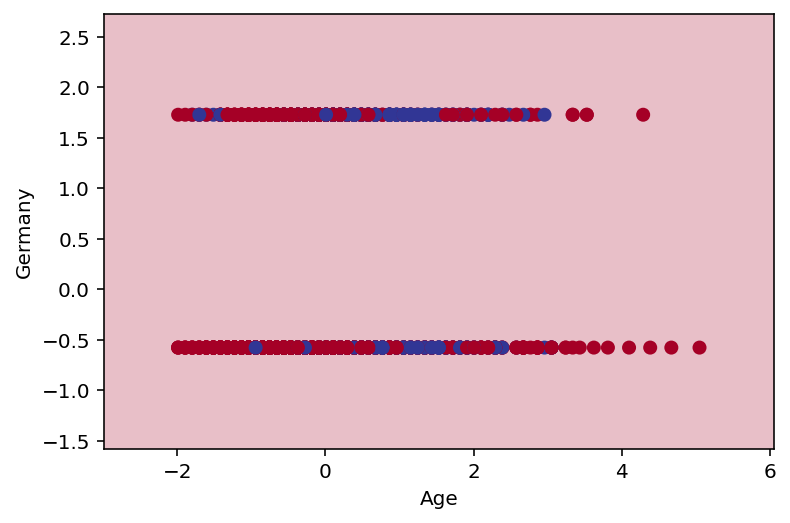

In [24]:
plot_classifier(linear, X_test_scaled, y_test, xlabel='Age', ylabel='Germany')

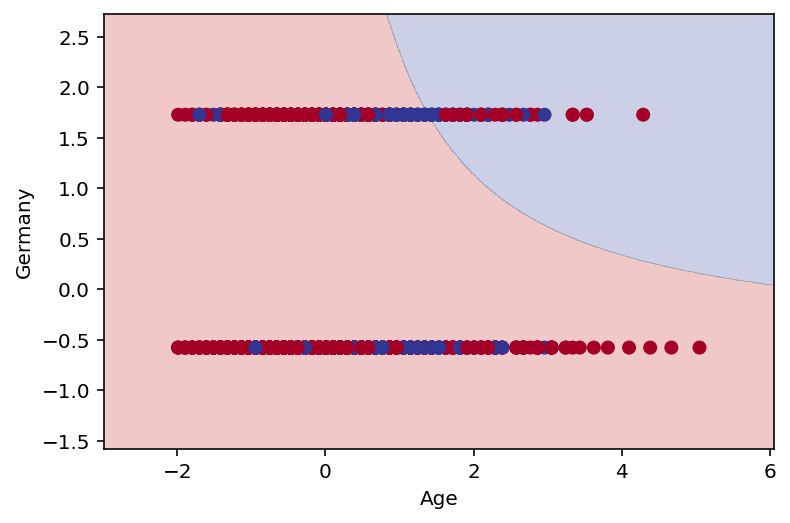

In [25]:
plot_classifier(poly, X_test_scaled, y_test, xlabel='Age', ylabel='Germany')

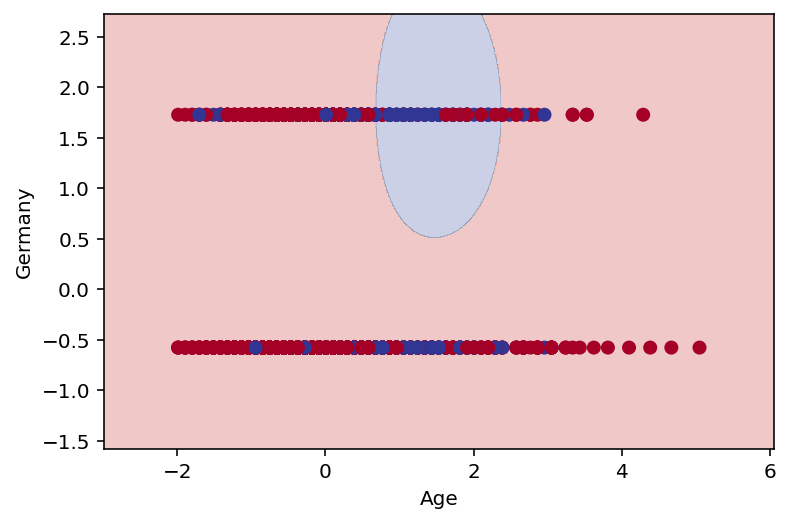

In [29]:
plot_classifier(rbf, X_test_scaled, y_test, xlabel='Age', ylabel='Germany')